In [1]:
import pymysql.cursors
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import pandas as pd
from math import sqrt
from sklearn.metrics import mean_squared_error
import datetime
from collections import Counter
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

In [2]:
# Utility method for querying to the database
def run_query(query):
    connection = pymysql.connect(host='52.66.79.237',
                             user='candidate',
                             password='asdfgh123',
                             db='servify_assignment',
                             charset='utf8mb4',
                             cursorclass=pymysql.cursors.DictCursor)
    cursor = connection.cursor()
    cursor.execute(query, None)
    return cursor.fetchall()

## Average number of plans sold per week

In [3]:
# get data
records = run_query("select SoldPlanID, DateOfPurchase from sold_plan")

Get start date and end date for all data points in sold_plan table.
Then convert these dates into matplotlib date num format for ease of use.

In [4]:
start_date = min([record['DateOfPurchase'] for record in records])
end_date = max([record['DateOfPurchase'] for record in records])

start_date_num = dates.datestr2num(start_date.strftime('%Y%m%d'))
end_date_num = dates.datestr2num(end_date.strftime('%Y%m%d'))

# array of all dates between start and end date
date_range = [x for x in range(int(start_date_num), int(end_date_num+1))]
date_range_str = [dates.num2date(x) for x in date_range]

Creating an array containing the count of purchases daily. Initialising with 0 and populating with the data one row at a time.

In [5]:
daily_plan_sold_array = [0]*len(date_range)
for record in records:
    date = record.get('DateOfPurchase')
    idx = int(dates.datestr2num(date.strftime('%Y%m%d'))) - int(start_date_num)
    daily_plan_sold_array[idx] += 1


Text(0.5, 1.0, 'Daily Plans Sold vs time')

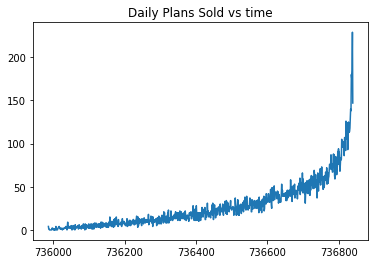

In [6]:
plt.plot(date_range, daily_plan_sold_array)
plt.title("Daily Plans Sold vs time")

In the figure above the numbers in the time axis represent dates. 

eg. 736800 represents 16/4/2018. (This conversion can be done using dates.num2date() method)

Average Plans sold per week is calculated by dividing all plans sold by total weeks.

In [7]:
total_plans_sold = len(records)
total_days = len(date_range)
total_weeks = total_days/7
average_plans_sold_per_week = len(records)/total_weeks
print(average_plans_sold_per_week)

190.5099648300117


#### Average Plans sold per week: 190.5099648300117

### The brand (BrandID) with the highest number of plans bought by customers.

This can be calculated using records of sold_plan joined with consumer_product on ConsumerProductID

In [8]:
joint_records = run_query("SELECT sold_plan.SoldPlanID, consumer_product.BrandID FROM sold_plan INNER JOIN "
                        "consumer_product ON sold_plan.ConsumerProductID=consumer_product.ConsumerProductID")

In [9]:
brandid_sold_array = [record['BrandID'] for record in joint_records]
top_5_brands = Counter(brandid_sold_array).most_common(5)
top_5_brands = [{'BrandID': brand, 'Count': count} for brand, count in top_5_brands]
print("Top 5 brands")
for brand in top_5_brands:
    print("BrandID: {}  has {} plans sold against it.".format(brand['BrandID'], brand['Count']))

Top 5 brands
BrandID: 16  has 267 plans sold against it.
BrandID: 86  has 265 plans sold against it.
BrandID: 23  has 262 plans sold against it.
BrandID: 7  has 261 plans sold against it.
BrandID: 21  has 259 plans sold against it.


### The percentage of service requests raised under a plan of the total number of requests raised.

This can be done using a single query on the database as shown. 

However, there is one thing to note about the data in consumer_servicerequest table. The SoldPlanID contains value 0 instead of NULL for rows indicating no plan sold for that consumer request. This is, in my opinion, a bad design. It should be NULL instead of 0. Because 0 may indicate a possible SoldPlanID. Thankfully that is not the case here.

In [10]:
result = run_query("SELECT a.on_plan_count/b.total_request as pc FROM (SELECT COUNT(*) AS on_plan_count FROM consumer_servicerequest WHERE SoldPlanID != 0 and SoldPlanID is not null) a, (SELECT COUNT(*) AS total_request FROM consumer_servicerequest) b")
print("Percentage of service requests raised under a plan = {:.2f}%".format(result[0]['pc']*100))

Percentage of service requests raised under a plan = 33.78%


Percentage of service requests raised under a plan = 33.78%

## Predicting Number of Consumers that will join in the next 3 months 

In [11]:
# getting consumer table data
consumer_records = run_query("select * from consumer")

In [12]:
# utility function for plotting time graph
def plot_time_graph(records, col_name):
    start_date = min([record[col_name] for record in records])
    end_date = max([record[col_name] for record in records])

    start_date_num = dates.datestr2num(start_date.strftime('%Y%m%d'))
    end_date_num = dates.datestr2num(end_date.strftime('%Y%m%d'))

    date_range = [x for x in range(int(start_date_num), int(end_date_num+1))]
    date_range_str = [dates.num2date(x) for x in date_range]
    
    daily_consumer_created_array = [0]*len(date_range)
    for record in records:
        date = record.get(col_name)
        idx = int(dates.datestr2num(date.strftime('%Y%m%d'))) - int(start_date_num)
        daily_consumer_created_array[idx] += 1
    
    plt.plot(date_range[:-1], daily_consumer_created_array[:-1])

Text(0.5, 1.0, 'Consumer records created vs Time')

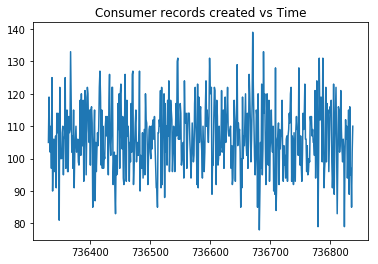

In [13]:
plot_time_graph(consumer_records, 'CreatedDate')
plt.title("Consumer records created vs Time")

In [14]:
# Converting data with required columns into a pandas dataframe
df = pd.DataFrame({'CreatedDate': [record['CreatedDate'] for record in consumer_records],
             'ConsumerID': [record['ConsumerID'] for record in consumer_records],
             'count': [1]*len(consumer_records)})

In [15]:
df.tail()

,CreatedDate,ConsumerID,count
54294,2017-06-19 22:40:32,999889,1
54295,2017-11-26 19:16:42,999898,1
54296,2017-11-17 03:21:35,999904,1
54297,2017-12-15 07:32:14,999941,1
54298,2017-11-24 04:32:56,999966,1


In [16]:
df.head()

,CreatedDate,ConsumerID,count
0,2018-02-13 01:12:37,27,1
1,2017-05-18 20:43:50,45,1
2,2018-05-02 19:20:38,49,1
3,2017-05-24 11:02:03,56,1
4,2017-01-31 11:30:24,61,1


Initially I thought of using CreatedDate column in the 'consumer' table to predict number of consumers joining in the next 3 months by considering CreatedDate as the date the consumer joined. But a quick look at the data showed that it is not the case. The CreatedDate column in the table is just the date when the record was created. It doesn't show the date when the consumer joined. We can see this taking some examples. 

Let us consider ConsumerID 45.

In [17]:
print(run_query("SELECT ConsumerID, CreatedDate FROM consumer where ConsumerID=45"))
print(run_query("SELECT ConsumerProductID, ConsumerID, DateOfPurchase FROM consumer_product where ConsumerID=45"))

[{'ConsumerID': 45, 'CreatedDate': datetime.datetime(2017, 5, 18, 20, 43, 50)}]
[{'ConsumerProductID': 2775347, 'ConsumerID': 45, 'DateOfPurchase': datetime.date(2016, 1, 20)}]


We can clearly see that for ConsumerID 45, the record in consumer table was created on 18/5/2017 whereas the same consumer purchased a product on 20/1/2016. So, we see that the record in consumer table was created more than a year after the consumer actually purchased a product. So, we cannot consider the CreatedDate in consumer table as the date of joining for a consumer. And so we will consider the earliest DateOfPurchase of any product by a consumer as that consumer's joining date. And if a consumer has no record in the consumer_product table, i.e. we do not have a record of his/her purchase, we will not consider such consumer in our dataset for prediction. Again this is because CreatedDate of a consumer does not reflect the joining date of that consumer.

In [18]:
print(run_query("SELECT COUNT(DISTINCT(ConsumerID)) FROM consumer_product"))

[{'COUNT(DISTINCT(ConsumerID))': 49788}]


Since there are product purchase records of only 49788 consumers, we will only be considering these for the prediction even though there are 54299 consumers in the consumer table. (Since we do not know the joining date of 4511(54299-49788) consumers)

In [19]:
consumer_product_records = run_query("select ConsumerProductID, ConsumerID, DateOfPurchase from consumer_product")

In [20]:
len(consumer_product_records)

50575

In [21]:
# utility function to convert data returned from run_query into pandas dataframe
def conv_to_df(records_dict_list):
    cols = records_dict_list[0].keys()
    records_dict = {}
    for col in cols:
        records_dict[col] = [record[col] for record in records_dict_list]
    return(pd.DataFrame(records_dict))

In [22]:
consumer_product_df = conv_to_df(consumer_product_records)

In [23]:
consumer_product_df.head()

,ConsumerProductID,ConsumerID,DateOfPurchase
0,113,653327,2017-05-02
1,148,749374,2017-04-08
2,832,532282,2016-05-25
3,1651,218144,2016-07-14
4,1785,813427,2018-05-20


In [24]:
# Considering only the earliest DateOfPurchase as joining date for consumers
idx = consumer_product_df.groupby(['ConsumerID'])['DateOfPurchase'].transform(min) == consumer_product_df['DateOfPurchase']

In [25]:
# filtered_df is the final dataset
filtered_df = consumer_product_df[idx][['DateOfPurchase']]
filtered_df['Count'] = 1
filtered_df = filtered_df.groupby(['DateOfPurchase']).sum()

In [26]:
filtered_df.head()

,Count
DateOfPurchase,
2016-01-01,62
2016-01-02,58
2016-01-03,46
2016-01-04,64
2016-01-05,53


Now we have a dataset containing joining dates of 49788 consumers with their count.

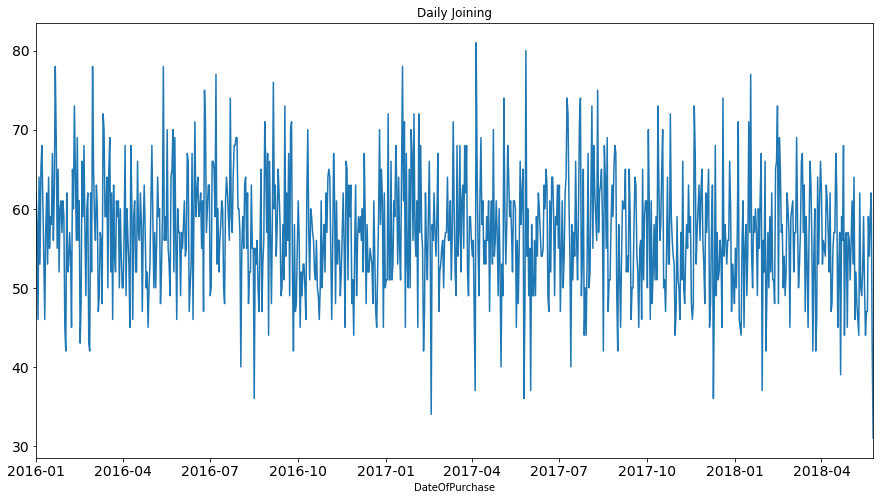

In [27]:
filtered_df.Count.plot(figsize=(15,8), title= 'Daily Joining', fontsize=14)

In [28]:
filtered_df.describe()

,Count
count,876.000000
mean,56.835616
std,7.627044
min,31.000000
25%,52.000000
50%,57.000000
75%,62.000000
max,81.000000


We have purchase dates starting from 01-01-2016 to 25-02-2018.  Here we will be dropping the last date 25-02-2018 from the dataset because the count for this date may not be complete.

In [29]:
filtered_df = filtered_df.drop(filtered_df.index[-1])

In [30]:
filtered_df.tail()

,Count
DateOfPurchase,
2018-05-20,59
2018-05-21,54
2018-05-22,59
2018-05-23,62
2018-05-24,43


In [31]:
filtered_df.index = pd.to_datetime(filtered_df.index)

In [32]:
# Getting the monthly count instead of the daily count as done above.
df = filtered_df.resample('m').sum()

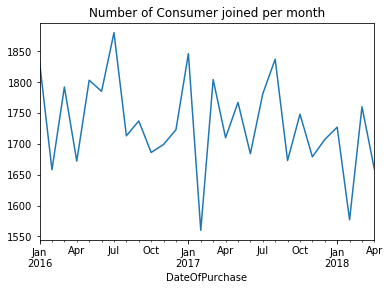

In [33]:
# Again dropping the last month of May since we are short of 6 days of data for this month.
df = df.drop(df.index[-1])
df.Count.plot(title='Number of Consumer joined per month')

Now in order to predict number of consumers joining in the next 3 months, we will use the daily aggregated data. Because we do not have enough data points for the monthly aggregated data. 

In [34]:
# Dividing Train - Test data set taking all days of March, April and May 2018 as test data and rest as train data
train = filtered_df.loc[:'2018-02-28']
test = filtered_df.loc['2018-03-01':]

#### Time series forecasting using ARIMA

Here we will use the popular ARIMA method for time series forecasting. Training ARIMA model using standard values of parameters. We will use Seasonal ARIMA to incorporate the seasonal variations in our data. However due to lack of time, no parameter tuning is done which is needed to get the best set of parameters.

C:\Users\ishit\Anaconda3\envs\aman_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\ishit\Anaconda3\envs\aman_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)
C:\Users\ishit\Anaconda3\envs\aman_env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\ishit\Anaconda3\envs\aman_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:336: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


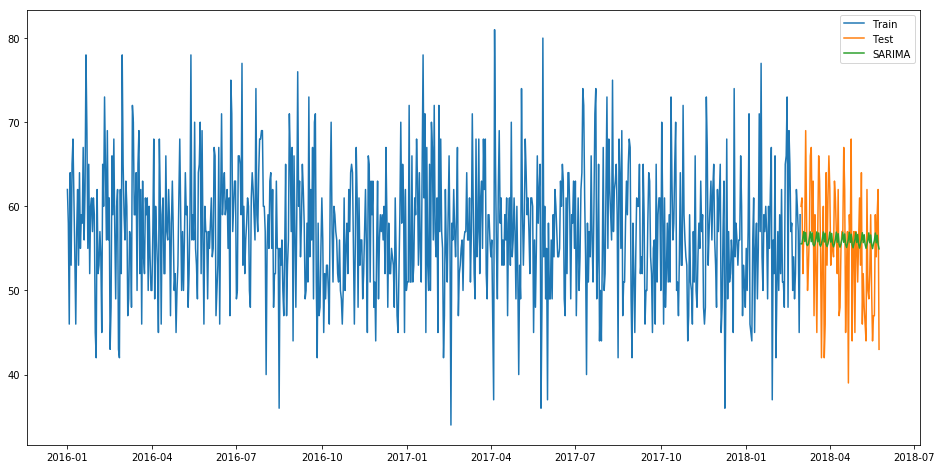

In [35]:
y_hat_avg = test.copy()
fit1 = sm.tsa.statespace.SARIMAX(train.Count, order=(2, 1, 4),seasonal_order=(0,1,1,7)).fit()
y_hat_avg['SARIMA'] = fit1.predict(start="2018-03-01", end="2018-05-24", dynamic=True)
plt.figure(figsize=(16,8))
plt.plot( train['Count'], label='Train')
plt.plot(test['Count'], label='Test')
plt.plot(y_hat_avg['SARIMA'], label='SARIMA')
plt.legend(loc='best')
plt.show()

In [36]:
rms = sqrt(mean_squared_error(test.Count, y_hat_avg.SARIMA))
print("RMSE: {}".format(rms))

RMSE: 6.909607111368619


In [37]:
predicted_daily = fit1.predict(start="2018-06-01", end="2018-08-31", dynamic=True)

C:\Users\ishit\Anaconda3\envs\aman_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:336: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)
C:\Users\ishit\Anaconda3\envs\aman_env\lib\site-packages\statsmodels\tsa\statespace\kalman_filter.py:1740: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  ' effect.', ValueWarning)


In [38]:
predicted_monthly = predicted_daily.resample('m').sum()

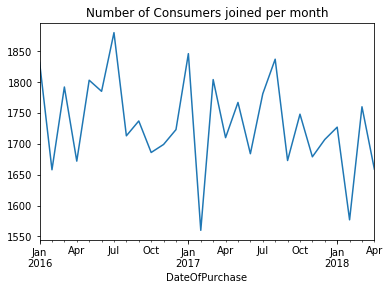

In [39]:
df.Count.plot(title="Number of Consumers joined per month")

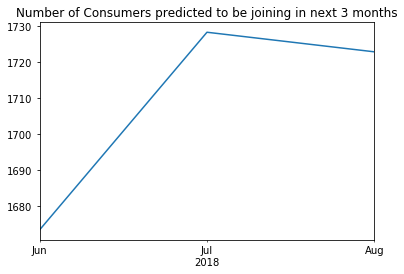

In [41]:
predicted_monthly.plot(title="Number of Consumers predicted to be joining in next 3 months")

In [42]:
predicted_monthly

2018-06-30    1673.353356
2018-07-31    1728.393992
2018-08-31    1722.940640
Freq: M, dtype: float64

### Number of consumers expected to join in the next 3 months 
1. June 2018: 1673
2. July 2018: 1728
3. August 2018: 1723

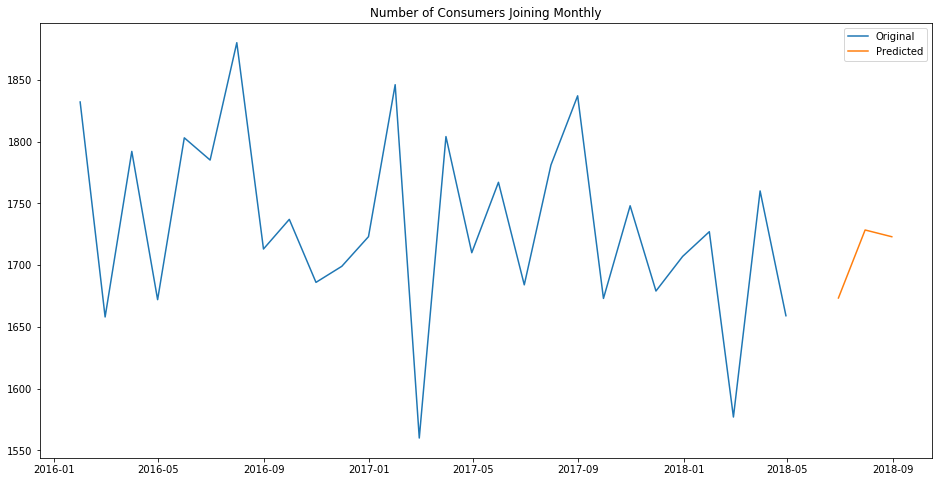

In [45]:
plt.figure(figsize=(16,8))
plt.title("Number of Consumers Joining Monthly")
plt.plot( df.Count, label='Original')
plt.plot(predicted_monthly, label='Predicted')
plt.legend(loc = 'best')

### The probability that a Service Request will originate against a Sold Plan.

Since time is limited, I will not be able to attempt this problem. 